In [1]:
import sys, traceback
import cv2
import numpy as np
import argparse
import string
import paramiko
from plantcv import plantcv as pcv
import psycopg2
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [82]:
data_server = '146.118.66.62'
data_user = 'readonlyuser'
data_password = 'readonlyuser'

image_server = '146.118.66.62'
image_user = 'ubuntu'
image_pkey = '/Users/a1132077/.ssh/id_rsa'

dbname = '0000_Production_N'
measurement_label = '0467 Barley'
id_tag = '073262-W'
camera_label = 'RGB_3D_3D_side_far_0'
time_stamp = '2019-04-23'

results_file = '/Users/a1132077/development/plantcv-pipeline/res.json'

plt.rcParams['figure.figsize'] = [20, 10]

# Get image path from database

In [83]:
# Connect to an existing database
conn = psycopg2.connect(host=data_server, dbname=dbname, user="readonlyuser", password="readonlyuser")

# Open a cursor to perform database operations
cur = conn.cursor()

# Query the database and obtain data as Python objects
cur.execute("""
SELECT path,
        measurement_label, 
       id_tag, 
       camera_label, 
       time_stamp, 
       image_oid
FROM   snapshot 
       JOIN tiled_image 
         ON snapshot.id = tiled_image.snapshot_id 
       JOIN tile 
         ON tiled_image.id = tile.tiled_image_id 
       JOIN image_file_table 
         ON tile.image_oid = image_file_table.id
WHERE measurement_label = '{measurement_label}'
AND camera_label = '{camera_label}'
AND id_tag = '{id_tag}'
AND date_trunc('day', time_stamp) = '{time_stamp}'
;
""".format(measurement_label=measurement_label,
          camera_label=camera_label,
          id_tag=id_tag,
          time_stamp=time_stamp))

result = cur.fetchone()
path = result[0]

for item in result:
    print(item)
    #print("{}:\t{}".format(i, databases[i]))

# Close communication with the database
cur.close()
conn.close()

2019-04-24/blob656136
0467 Barley
073262-W
RGB_3D_3D_side_far_0
2019-04-23 22:42:37.453000+00:00
656136


# Load image via SFTP

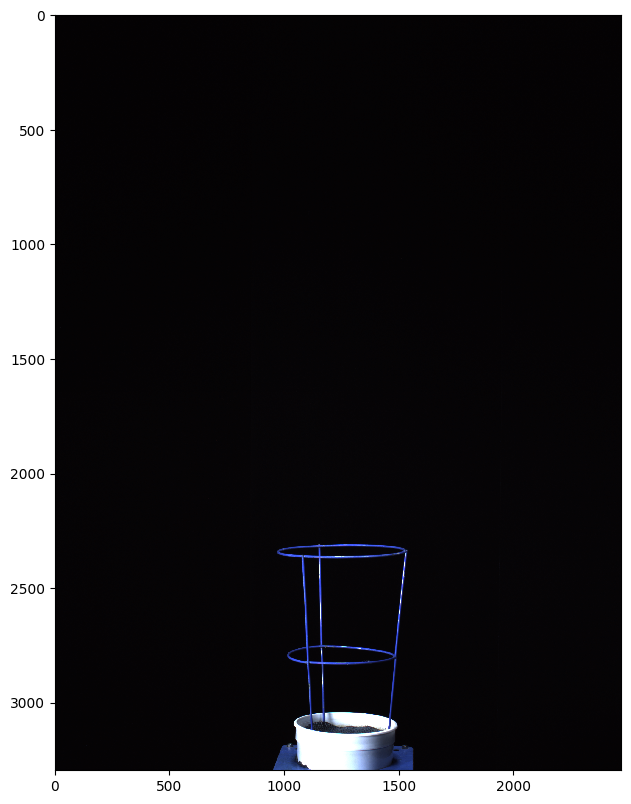

In [84]:
mykey = paramiko.RSAKey.from_private_key_file(image_pkey)
server = image_server
sshuser = image_user

client = paramiko.SSHClient()
client.load_system_host_keys()
client.connect(server, username = sshuser, pkey = mykey)

pcv.params.debug = 'plot'

sftp = client.open_sftp()
with sftp.open('/plantdb/ftp-2019/{dbname}/{path}'.format(dbname=dbname,path=path)) as f:
  file_size = f.stat().st_size
  f.prefetch(file_size)
  img = cv2.imdecode(np.frombuffer(f.read(), np.uint8), 1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

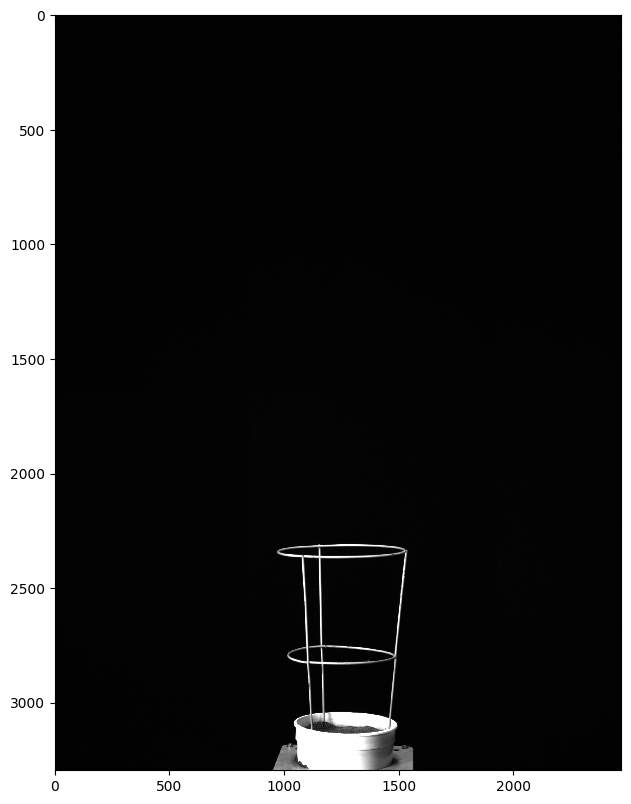

In [85]:
# Convert RGB to HSV and extract the value channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='v')

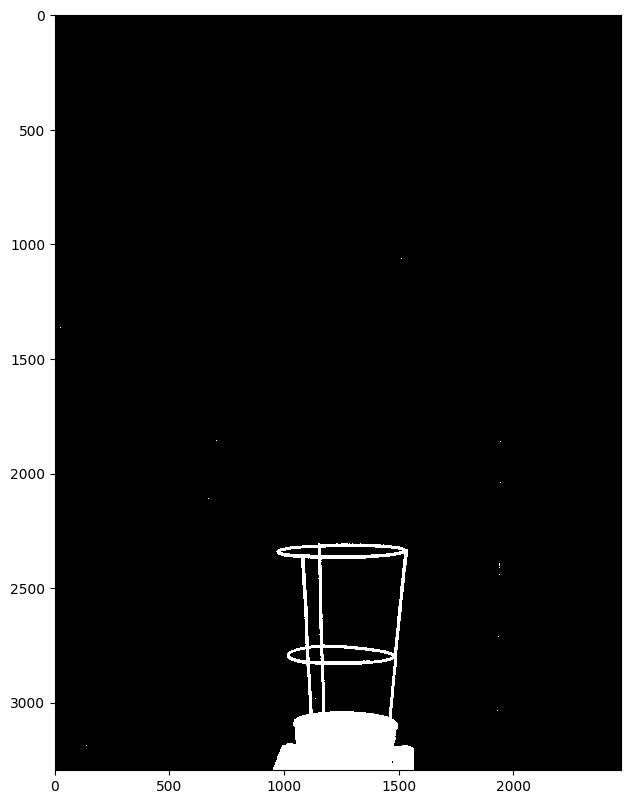

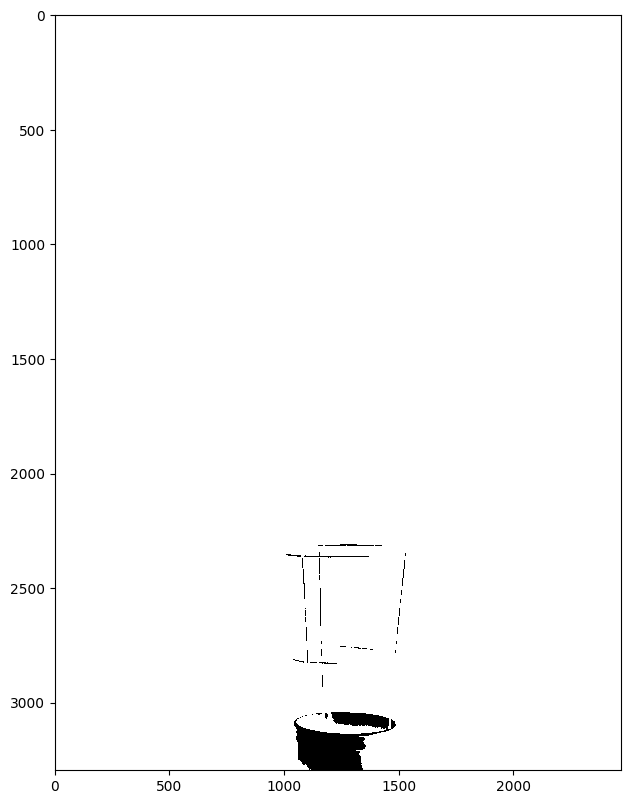

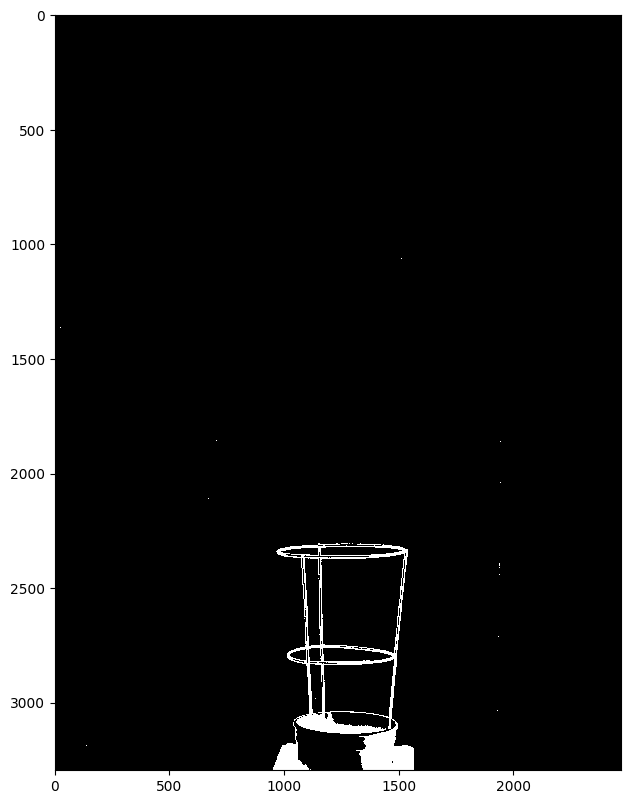

In [86]:
# Threshold the saturation image removing highs and lows and join
s_thresh_1 = pcv.threshold.binary(gray_img=s, threshold=10, max_value=255, object_type='light')
s_thresh_2 = pcv.threshold.binary(gray_img=s, threshold=245, max_value=255, object_type='dark')
s_thresh = pcv.logical_and(bin_img1=s_thresh_1, bin_img2=s_thresh_2)

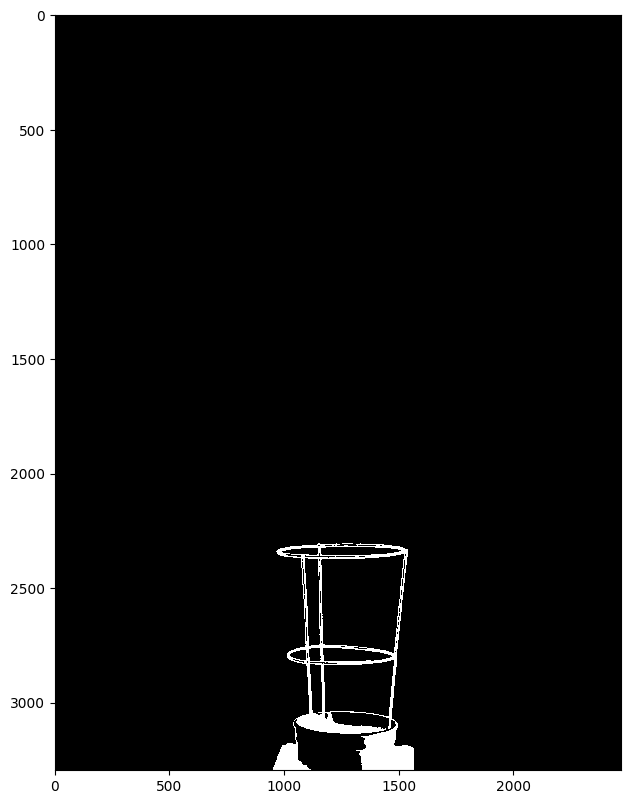

In [87]:
# Median Blur
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)

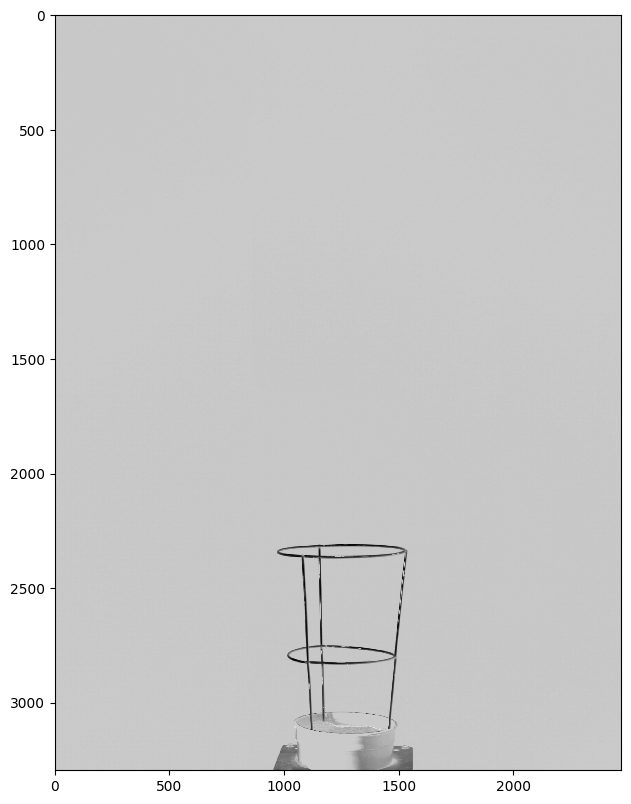

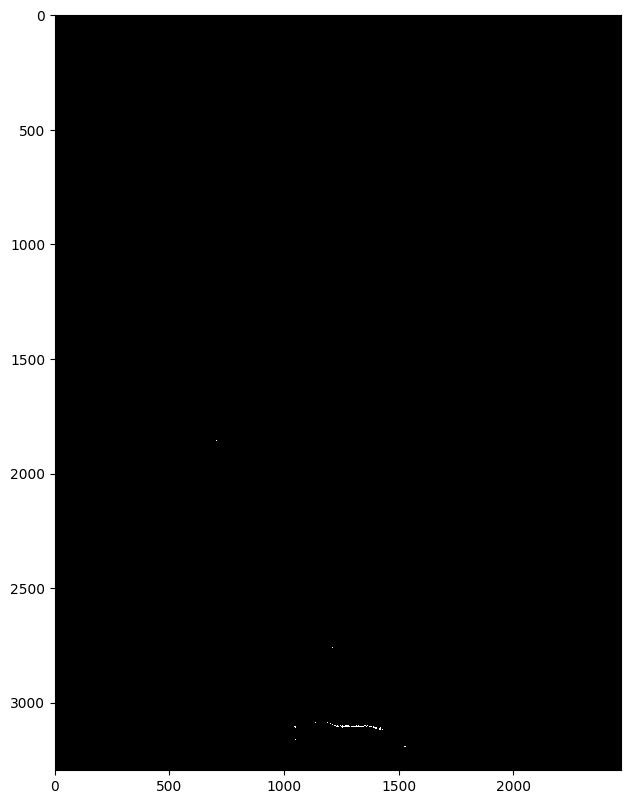

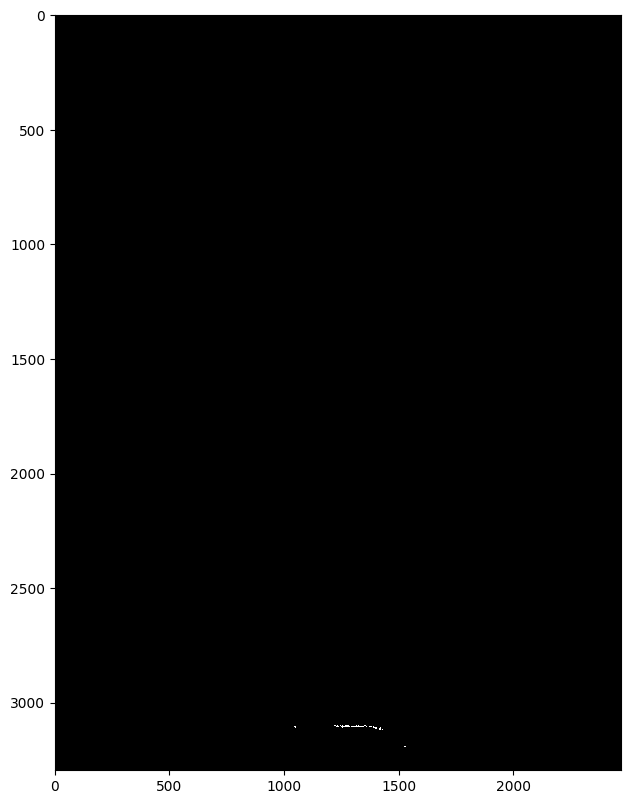

In [88]:
# Convert RGB to LAB and extract the Blue channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_cnt = pcv.threshold.binary(gray_img=b, threshold=128, max_value=255, object_type='light')

# Fill small objects
b_fill = pcv.fill(b_cnt, 10)

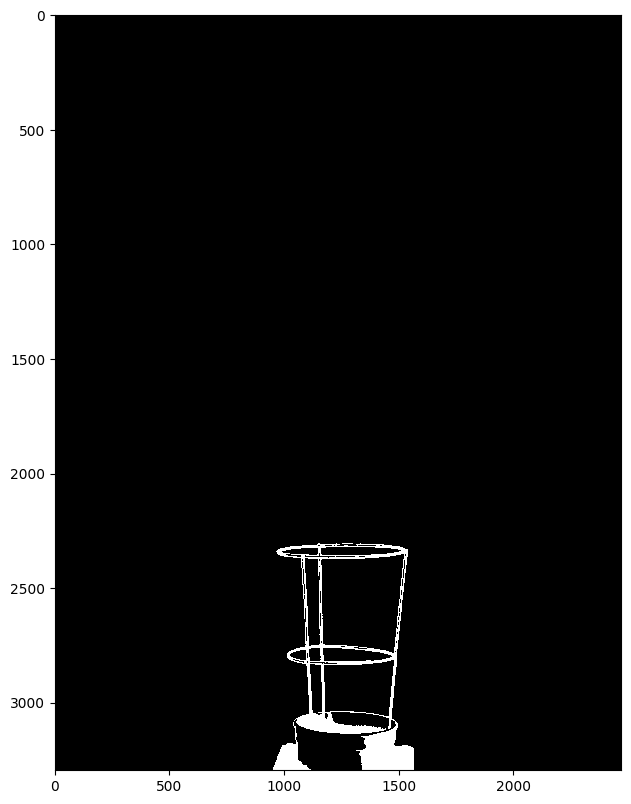

In [89]:
# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_fill)

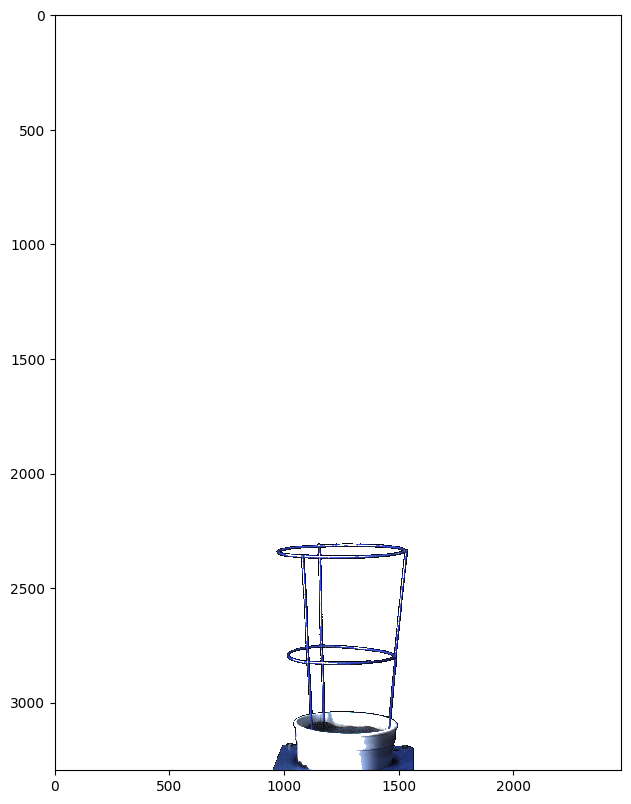

In [90]:
# Apply Mask (for VIS images, mask_color=white)
masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')

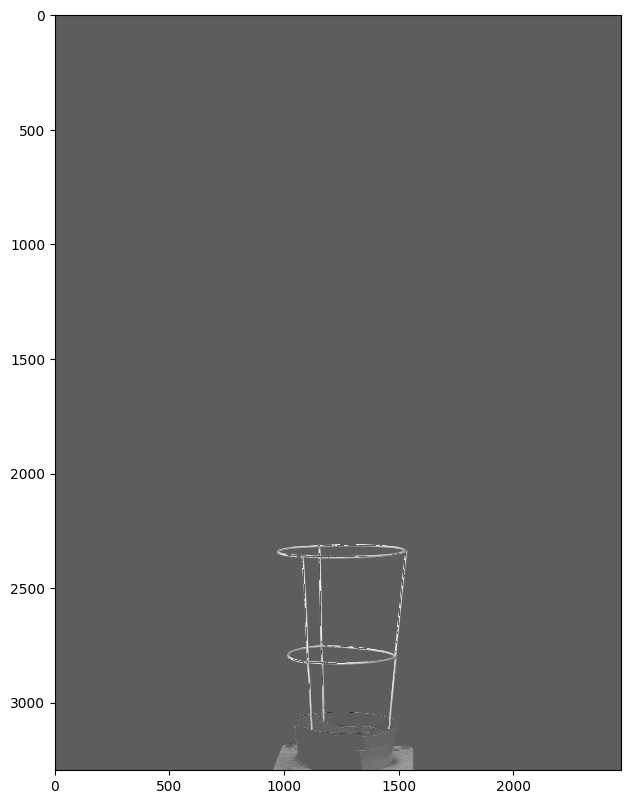

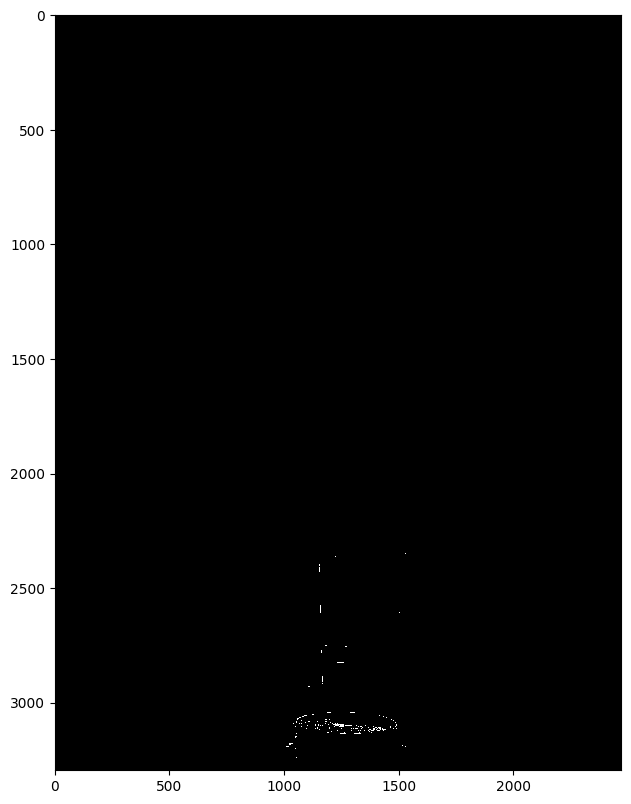

In [91]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
# Threshold the green-magenta and blue images

masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=127, max_value=255, object_type='dark')

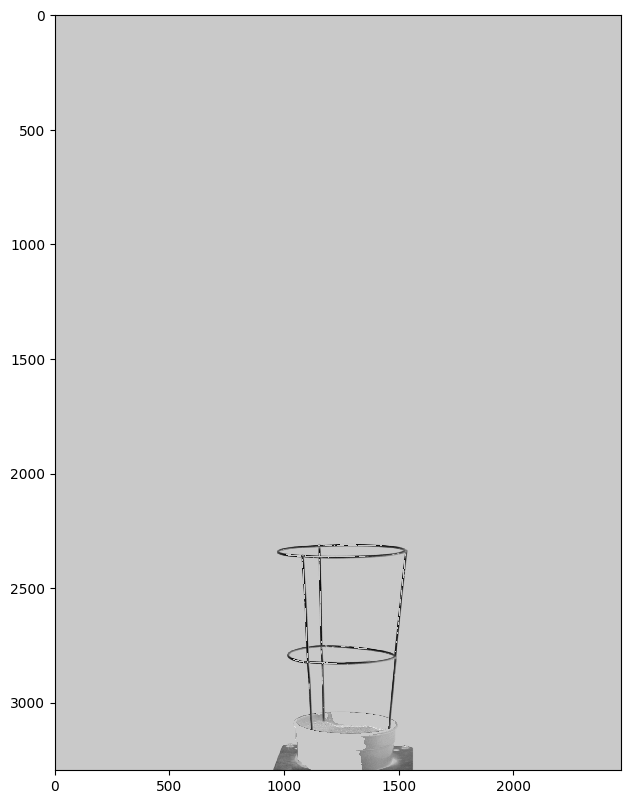

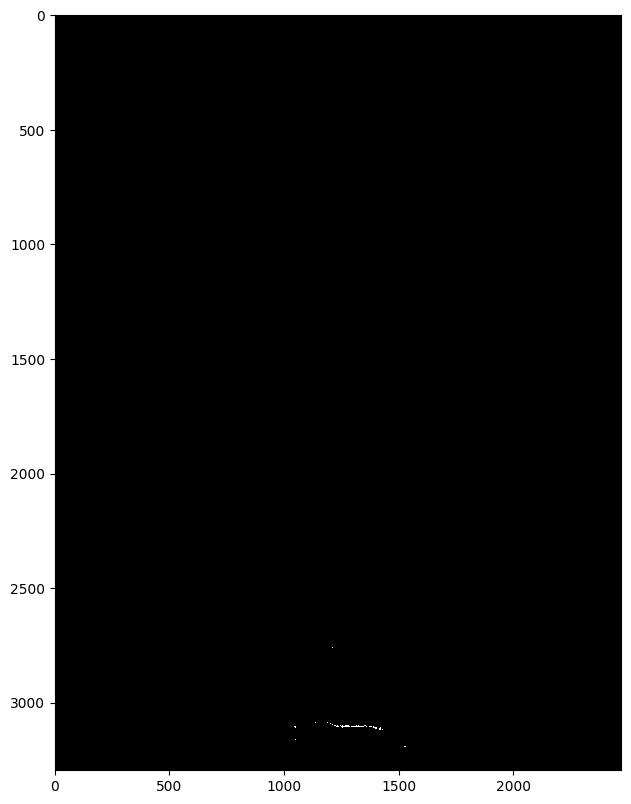

In [92]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
# Threshold the green-magenta and blue images
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')

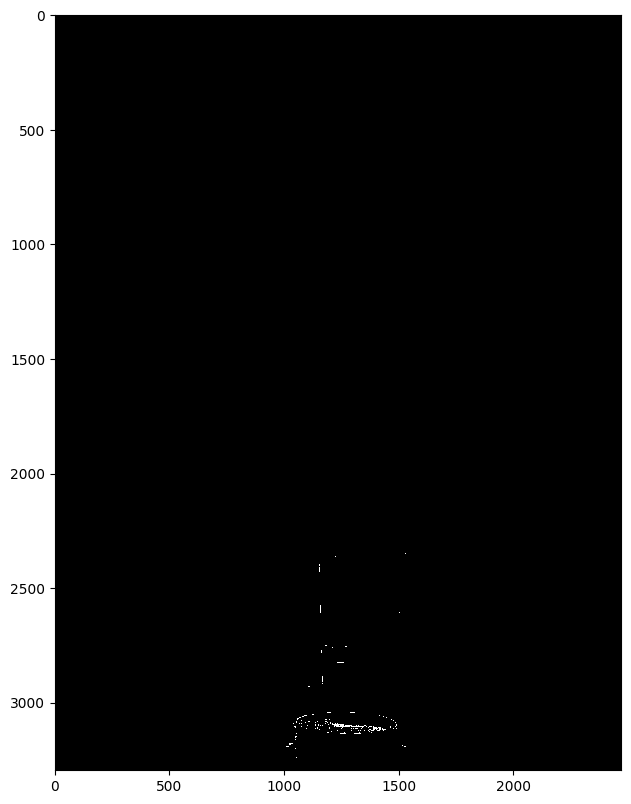

In [93]:
# Join the thresholded saturation and blue-yellow images (OR)
ab = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)

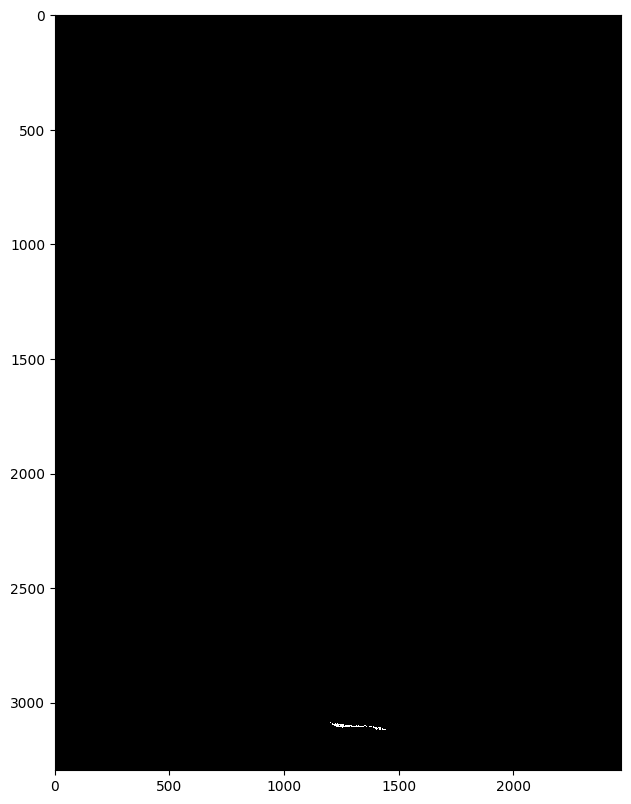

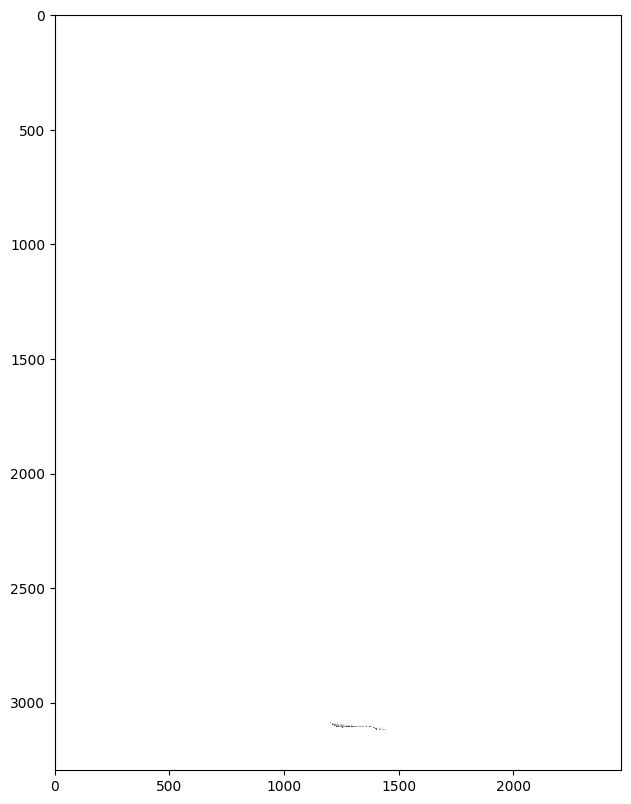

In [94]:
# Fill small objects
ab_fill = pcv.fill(bin_img=ab, size=200)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')

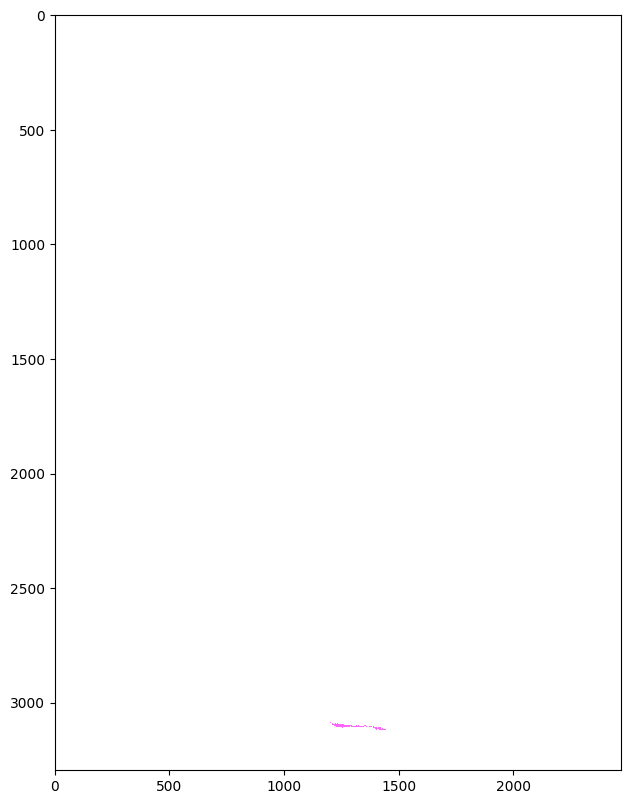

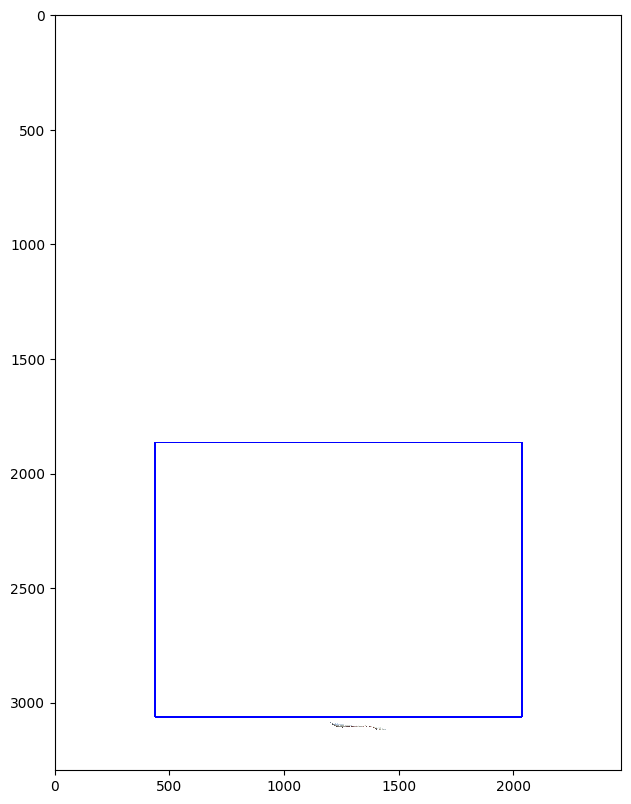

In [95]:
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)

# Define ROI

W = 2472
H = 3296

if "far" in camera_label:
    # SIDE FAR
    w = 1600
    h = 1200
    pot = 230#340
    roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=(W-w)/2, y=(H-h-pot), h=h, w=w)
elif "lower" in camera_label:
    # SIDE LOWER 
    w = 800
    h = 2400
    pot = 340
    roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=1000-w/2, y=(H-h-pot), h=h, w=w)
elif "upper" in camera_label:
    # SIDE UPPER
    w = 600
    h = 800
    pot = 550
    roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=1400-w/2, y=(H-h-pot), h=h, w=w)
elif "top" in camera_label:
    # TOP
    w = 450
    h = 450
    roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=(H-h)/2, y=(W-w)/2, h=h, w=w)



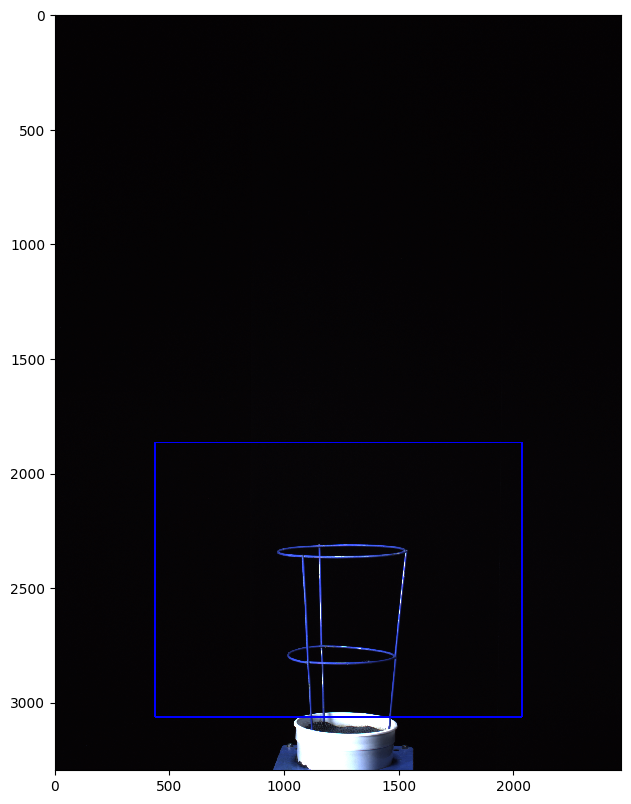

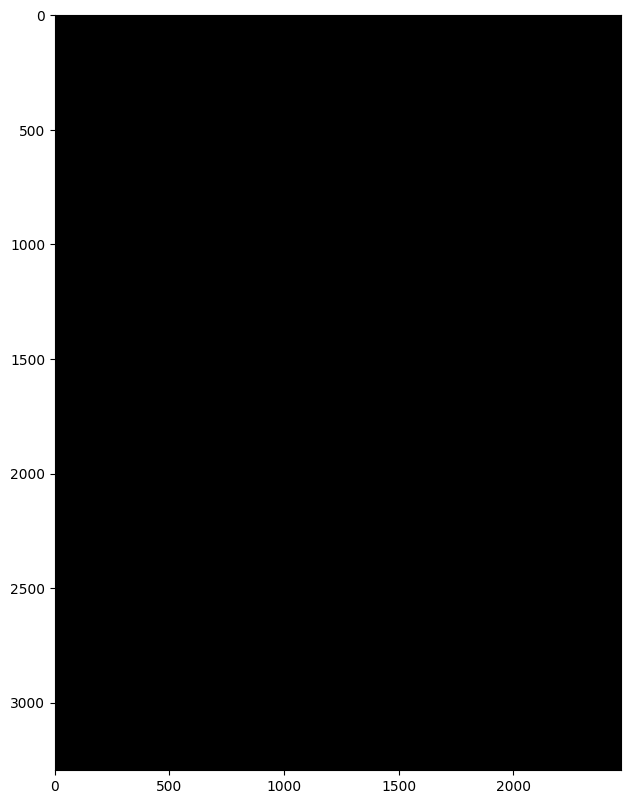

In [96]:
# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                           roi_hierarchy=roi_hierarchy, 
                                                           object_contour=id_objects, 
                                                           obj_hierarchy=obj_hierarchy,
                                                           roi_type='partial')

In [98]:
# Object combine kept objects
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

# Find shape properties, output shape image (optional)
shape_imgs = pcv.analyze_object(img=img, obj=obj, mask=mask)

#if args.writeimg == True:

#pcv.print_image(img=shape_imgs,filename="{}_shape.png".format(results_file[:-5]))
#pcv.print_image(img=masked2,filename="{}_obj_on_img.png".format(results_file[:-5]))

TypeError: object of type 'NoneType' has no len()

In [35]:
# Shape properties relative to user boundary line (optional)
#boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, line_position=1680)



/Users/a1132077/Library/Python/3.6/lib/python/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/a1132077/Library/Python/3.6/lib/python/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


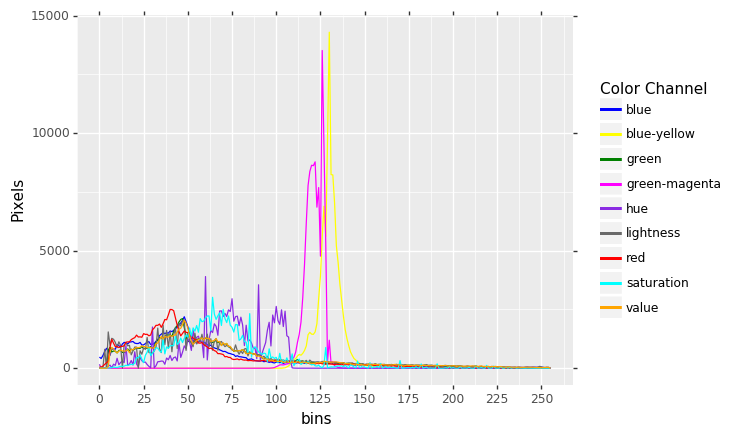

<ggplot: (331974464)>


In [19]:
# Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')



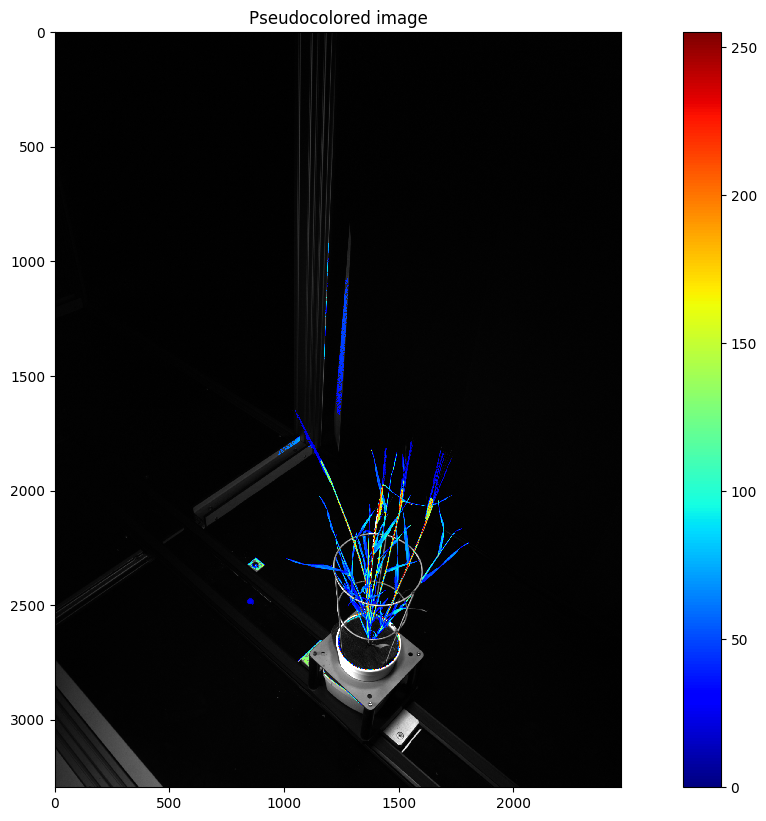

In [20]:

# Pseudocolor the grayscale image
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, mask=kept_mask, cmap='jet')

In [21]:
# Write shape and color data to results file
#pcv.print_results(filename=results_file)
print(pcv.outputs.observations)

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 112918.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 1106050.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.10209117938104996, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 32592.121019601822, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'va